In [6]:
#--help
%run main.py --help

usage: main.py [-h] [--LR_path LR_PATH] [--GT_path GT_PATH] [--val_LR_path VAL_LR_PATH] [--val_GT_path VAL_GT_PATH]
               [--res_num RES_NUM] [--num_workers NUM_WORKERS] [--batch_size BATCH_SIZE] [--L2_coeff L2_COEFF]
               [--adv_coeff ADV_COEFF] [--tv_loss_coeff TV_LOSS_COEFF] [--pre_train_epoch PRE_TRAIN_EPOCH]
               [--fine_train_epoch FINE_TRAIN_EPOCH] [--scale SCALE] [--patch_size PATCH_SIZE]
               [--feat_layer FEAT_LAYER] [--vgg_rescale_coeff VGG_RESCALE_COEFF] [--fine_tuning]
               [--in_memory IN_MEMORY] [--generator_path GENERATOR_PATH] [--mode MODE] [--tile_size TILE_SIZE]
               [--overlap OVERLAP] [--output_path OUTPUT_PATH]

optional arguments:
  -h, --help            show this help message and exit
  --LR_path LR_PATH
  --GT_path GT_PATH
  --val_LR_path VAL_LR_PATH
  --val_GT_path VAL_GT_PATH
  --res_num RES_NUM
  --num_workers NUM_WORKERS
  --batch_size BATCH_SIZE
  --L2_coeff L2_COEFF
  --adv_coeff ADV_COEFF
  --tv_

In [3]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA Device Name:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("CUDA not available, using CPU.")


CUDA Device Name: NVIDIA GeForce GTX 1650


Total training patches: 7200


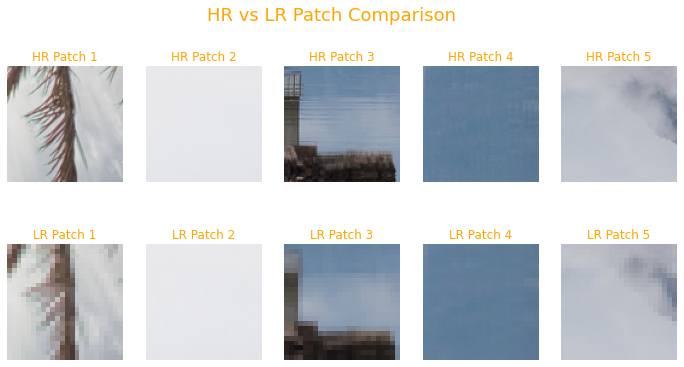

In [4]:
#To check if the number of patches and the output samples are aligned and correct [Train]
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch
from adverserial_dataset import DIV2KTrainSet

# Initialize Training Dataset & DataLoader
train_set = DIV2KTrainSet(
    hr_dir="C:/Users/User/Desktop/SRGAN - Copy/div2k_train_val/train/train_hr/",
    lr_dir="C:/Users/User/Desktop/SRGAN - Copy/div2k_train_val/train/train_lr/",
    patch_size=96
)

trainloader = DataLoader(train_set, batch_size=1, shuffle=True)
print(f"Total training patches: {len(train_set)}")  # Display total patches

# Load a few samples
num_samples = 5
fig, axes = plt.subplots(2, num_samples, figsize=(12, 6))  # 2 rows (HR/LR), 5 columns

for i in range(num_samples):
    hr_patch, lr_patch = train_set[i+29] #adjust the value to the desired patches 

    hr_patch_np = hr_patch.permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5  # De-normalize HR
    lr_patch_np = lr_patch.permute(1, 2, 0).cpu().numpy()  # LR (already normalized correctly)

    # HR Patch
    axes[0, i].imshow(hr_patch_np)
    axes[0, i].set_title(f"HR Patch {i+1}", fontsize=12, color='orange')
    axes[0, i].axis("off")

    # LR Patch
    axes[1, i].imshow(lr_patch_np)
    axes[1, i].set_title(f"LR Patch {i+1}", fontsize=12, color='orange')
    axes[1, i].axis("off")

plt.suptitle("HR vs LR Patch Comparison", fontsize=18, color='orange')
plt.show()

Total validation images: 90


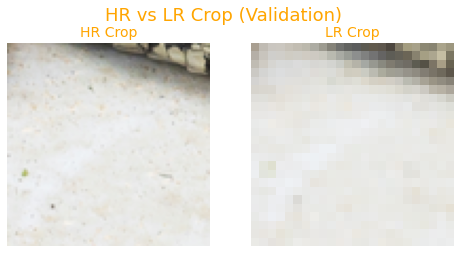

In [3]:
##To check if the number of patches and the output samples are aligned and correct [Validate]
from adverserial_dataset import DIV2KValidSet  # Ensure the dataset class is correctly imported
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch

# Define validation directories
val_hr_dir = "C:/Users/User/Desktop/SRGAN - Copy/div2k_train_val/val/val_hr/"
val_lr_dir = "C:/Users/User/Desktop/SRGAN - Copy/div2k_train_val/val/val_lr/"

# Initialize Validation Dataset & DataLoader
valid_set = DIV2KValidSet(
    hr_dir=val_hr_dir,
    lr_dir=val_lr_dir,
    #crop_size=128  # Center crop size
)

validloader = DataLoader(valid_set, batch_size=1, shuffle=False)
print(f"Total validation images: {len(valid_set)}")

# Fetch a validation sample
hr_crop, lr_crop = valid_set[19]  # Get first validation pair

# Convert HR & LR to NumPy for visualization
hr_crop_np = hr_crop.permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5  # De-normalize HR
lr_crop_np = lr_crop.permute(1, 2, 0).cpu().numpy()  # LR (not normalized)

# Plot the HR and LR crops
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
fig.suptitle("HR vs LR Crop (Validation)", fontsize=18, color='orange')

# HR Image
axes[0].imshow(hr_crop_np)
axes[0].set_title("HR Crop", fontsize=14, color='orange')
axes[0].axis("off")

# LR Image
axes[1].imshow(lr_crop_np)
axes[1].set_title("LR Crop", fontsize=14, color='orange')
axes[1].axis("off")

plt.show()

In [8]:
#Memory checking
from srgan_model import Generator, Discriminator  # Adjust import as needed
from vgg19 import vgg19       # Adjust import as needed
import torch

def check_model_memory(model, name, input_shape=(1, 3, 96, 96), device='cuda'):
    print(f"\n--- Checking memory for {name} ---")
    model = model.to(device)
    dummy_input = torch.randn(input_shape).to(device)

    torch.cuda.reset_peak_memory_stats()
    
    with torch.no_grad():
        _ = model(dummy_input)

    allocated = torch.cuda.memory_allocated(device) / (1024 ** 2)  # MB
    peak = torch.cuda.max_memory_allocated(device) / (1024 ** 2)  # MB
    print(f"{name} - Current Allocated: {allocated:.2f} MB | Peak Allocated: {peak:.2f} MB")

    del dummy_input
    del model
    torch.cuda.empty_cache()


check_model_memory(Generator(), "Generator")
check_model_memory(Discriminator(), "Discriminator")
check_model_memory(vgg19(), "VGG")




--- Checking memory for Generator ---
Generator - Current Allocated: 27.87 MB | Peak Allocated: 111.68 MB

--- Checking memory for Discriminator ---
Discriminator - Current Allocated: 107.91 MB | Peak Allocated: 121.40 MB

--- Checking memory for VGG ---
VGG - Current Allocated: 106.58 MB | Peak Allocated: 132.56 MB


## SRGAN  (if generator slow then change the main.py in memory to True again)

In [9]:
#Upscale Bicubic
# For a single image
#%run upscale_bicubic.py --input path/to/image.jpg --output path/to/output/upscaled_image.jpg


# For a folder of images
#%run upscale_bicubic.py --input path/to/image_folder --output path/to/output_folder
%run upscale_bicubic.py --input "C:/Users/User/Desktop/SRGAN - Copy/div2k_train_val/outputs/test/lr" --output "C:/Users/User/Desktop/SRGAN - Copy/div2k_train_val/outputs/test/bicubic"          

Upscaling images: 100%|███████████████████████████████████████████████████████████████| 32/32 [00:27<00:00,  1.15img/s]


In [1]:
%run main.py --mode train --LR_path "C:/Users/User/Desktop/SRGAN - Copy/div2k_train_val/train/train_lr" --GT_path "C:/Users/User/Desktop/SRGAN - Copy/div2k_train_val/train/train_hr" --fine_tuning --generator_path "C:/Users/User/Desktop/SRGAN - Copy/SRResNet.pt"                               

C:\Users\User\Desktop\SRGAN - Copy\srgan_model\test_mode.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load(args.generator_path))


pre-trained model is loaded
path : C:/Users/User/Desktop/SRGAN - Copy/SRResNet.pt


Pretrain Epoch 1/15: 100%|█████████████████████████████████████████████████████████████| 45/45 [02:15<00:00,  3.02s/it]


1
0.0077828336507081985


Pretrain Epoch 2/15: 100%|█████████████████████████████████████████████████████████████| 45/45 [02:15<00:00,  3.00s/it]


2
0.013519234023988247


Pretrain Epoch 3/15: 100%|█████████████████████████████████████████████████████████████| 45/45 [02:33<00:00,  3.41s/it]


3
0.009536230005323887


Pretrain Epoch 4/15: 100%|█████████████████████████████████████████████████████████████| 45/45 [02:34<00:00,  3.44s/it]


4
0.01096374448388815


Pretrain Epoch 5/15: 100%|█████████████████████████████████████████████████████████████| 45/45 [02:33<00:00,  3.41s/it]


5
0.008484480902552605


Pretrain Epoch 6/15: 100%|█████████████████████████████████████████████████████████████| 45/45 [02:35<00:00,  3.45s/it]


6
0.020949367433786392


Pretrain Epoch 7/15: 100%|█████████████████████████████████████████████████████████████| 45/45 [02:32<00:00,  3.40s/it]


7
0.013439158909022808


Pretrain Epoch 8/15: 100%|█████████████████████████████████████████████████████████████| 45/45 [02:45<00:00,  3.69s/it]


8
0.012898397631943226


Pretrain Epoch 9/15: 100%|█████████████████████████████████████████████████████████████| 45/45 [02:41<00:00,  3.60s/it]


9
0.01127288956195116


Pretrain Epoch 10/15: 100%|████████████████████████████████████████████████████████████| 45/45 [02:07<00:00,  2.83s/it]


10
0.016212129965424538


Pretrain Epoch 11/15: 100%|████████████████████████████████████████████████████████████| 45/45 [02:06<00:00,  2.82s/it]


11
0.009304266422986984


Pretrain Epoch 12/15: 100%|████████████████████████████████████████████████████████████| 45/45 [02:07<00:00,  2.84s/it]


12
0.007848733104765415


Pretrain Epoch 13/15: 100%|████████████████████████████████████████████████████████████| 45/45 [02:07<00:00,  2.84s/it]


13
0.010132716037333012


Pretrain Epoch 14/15: 100%|████████████████████████████████████████████████████████████| 45/45 [02:08<00:00,  2.84s/it]


14
0.012835964560508728


Pretrain Epoch 15/15: 100%|████████████████████████████████████████████████████████████| 45/45 [02:07<00:00,  2.83s/it]
C:\Users\User\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


15
0.009342662058770657


C:\Users\User\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
Adversarial Epoch 1/35: 100%|██████████████████████████████████████████████████████████| 45/45 [02:21<00:00,  3.14s/it]


1
0.009027926251292229
1.379724144935608


Adversarial Epoch 2/35: 100%|██████████████████████████████████████████████████████████| 45/45 [02:20<00:00,  3.12s/it]


2
0.011229694820940495
1.3529108762741089


Adversarial Epoch 3/35: 100%|██████████████████████████████████████████████████████████| 45/45 [02:19<00:00,  3.10s/it]


3
0.016071941703557968
0.790195107460022


Adversarial Epoch 4/35: 100%|██████████████████████████████████████████████████████████| 45/45 [02:20<00:00,  3.12s/it]


4
0.016186656430363655
1.6421006917953491


Adversarial Epoch 5/35: 100%|██████████████████████████████████████████████████████████| 45/45 [02:21<00:00,  3.14s/it]


5
0.016448281705379486
0.7957866787910461


Adversarial Epoch 6/35: 100%|██████████████████████████████████████████████████████████| 45/45 [02:18<00:00,  3.08s/it]


6
0.031435538083314896
2.5878655910491943


Adversarial Epoch 7/35: 100%|██████████████████████████████████████████████████████████| 45/45 [02:17<00:00,  3.06s/it]


7
0.011067971587181091
1.2103147506713867


Adversarial Epoch 8/35: 100%|██████████████████████████████████████████████████████████| 45/45 [02:21<00:00,  3.14s/it]


8
0.01360076479613781
0.9947121739387512


Adversarial Epoch 9/35: 100%|██████████████████████████████████████████████████████████| 45/45 [02:18<00:00,  3.09s/it]


9
0.01741446927189827
0.6356374025344849


Adversarial Epoch 10/35: 100%|█████████████████████████████████████████████████████████| 45/45 [02:18<00:00,  3.08s/it]


10
0.017085721716284752
0.6589128375053406


Adversarial Epoch 11/35: 100%|█████████████████████████████████████████████████████████| 45/45 [02:18<00:00,  3.07s/it]


11
0.013232972472906113
0.5495781302452087


Adversarial Epoch 12/35: 100%|█████████████████████████████████████████████████████████| 45/45 [02:18<00:00,  3.09s/it]


12
0.012462182901799679
0.8434336185455322


Adversarial Epoch 13/35: 100%|█████████████████████████████████████████████████████████| 45/45 [02:18<00:00,  3.08s/it]


13
0.007964018732309341
1.1244304180145264


Adversarial Epoch 14/35: 100%|█████████████████████████████████████████████████████████| 45/45 [02:18<00:00,  3.08s/it]


14
0.011883063241839409
1.5445951223373413


Adversarial Epoch 15/35: 100%|█████████████████████████████████████████████████████████| 45/45 [02:18<00:00,  3.08s/it]


15
0.01575521193444729
0.2721751630306244


Adversarial Epoch 16/35: 100%|█████████████████████████████████████████████████████████| 45/45 [02:18<00:00,  3.07s/it]


16
0.014602713286876678
3.557155132293701


Adversarial Epoch 17/35: 100%|█████████████████████████████████████████████████████████| 45/45 [02:18<00:00,  3.09s/it]


17
0.0229698084294796
0.09980324655771255


Adversarial Epoch 18/35: 100%|█████████████████████████████████████████████████████████| 45/45 [02:18<00:00,  3.07s/it]


18
0.01327239628881216
0.5955124497413635


Adversarial Epoch 19/35: 100%|█████████████████████████████████████████████████████████| 45/45 [02:17<00:00,  3.06s/it]


19
0.015498269349336624
0.3584193289279938


Adversarial Epoch 20/35: 100%|█████████████████████████████████████████████████████████| 45/45 [03:55<00:00,  5.23s/it]


20
0.01208062656223774
0.1777115911245346


Adversarial Epoch 21/35: 100%|█████████████████████████████████████████████████████████| 45/45 [03:38<00:00,  4.86s/it]


21
0.013220705091953278
0.2554740607738495


Adversarial Epoch 22/35: 100%|█████████████████████████████████████████████████████████| 45/45 [03:43<00:00,  4.96s/it]


22
0.012369910255074501
1.045854091644287


Adversarial Epoch 23/35: 100%|█████████████████████████████████████████████████████████| 45/45 [03:42<00:00,  4.94s/it]


23
0.014618027955293655
0.3688696324825287


Adversarial Epoch 24/35: 100%|█████████████████████████████████████████████████████████| 45/45 [03:48<00:00,  5.08s/it]


24
0.012811509892344475
0.8338606357574463


Adversarial Epoch 25/35: 100%|█████████████████████████████████████████████████████████| 45/45 [03:39<00:00,  4.89s/it]


25
0.017665918916463852
0.1624923050403595


Adversarial Epoch 26/35: 100%|█████████████████████████████████████████████████████████| 45/45 [03:11<00:00,  4.26s/it]


26
0.023820973932743073
0.26788002252578735


Adversarial Epoch 27/35: 100%|█████████████████████████████████████████████████████████| 45/45 [02:17<00:00,  3.05s/it]


27
0.022197548300027847
0.36185717582702637


Adversarial Epoch 28/35: 100%|█████████████████████████████████████████████████████████| 45/45 [02:19<00:00,  3.11s/it]


28
0.02243604138493538
0.13750678300857544


Adversarial Epoch 29/35: 100%|█████████████████████████████████████████████████████████| 45/45 [02:21<00:00,  3.14s/it]


29
0.02256319858133793
0.3071618974208832


Adversarial Epoch 30/35: 100%|█████████████████████████████████████████████████████████| 45/45 [02:19<00:00,  3.10s/it]


30
0.018613670021295547
0.8463477492332458


Adversarial Epoch 31/35: 100%|█████████████████████████████████████████████████████████| 45/45 [02:40<00:00,  3.56s/it]


31
0.02059820480644703
0.3532694876194


Adversarial Epoch 32/35: 100%|█████████████████████████████████████████████████████████| 45/45 [02:37<00:00,  3.49s/it]


32
0.01174527034163475
0.44319865107536316


Adversarial Epoch 33/35: 100%|█████████████████████████████████████████████████████████| 45/45 [02:19<00:00,  3.11s/it]


33
0.018692802637815475
1.6180782318115234


Adversarial Epoch 34/35: 100%|█████████████████████████████████████████████████████████| 45/45 [02:18<00:00,  3.08s/it]


34
0.012556578032672405
0.6995778679847717


Adversarial Epoch 35/35: 100%|█████████████████████████████████████████████████████████| 45/45 [02:18<00:00,  3.07s/it]


35
0.011742926202714443
0.41517284512519836


In [2]:
#test
%run main.py --mode test --LR_path "C:/Users/User/Desktop/SRGAN - Copy/div2k_train_val/outputs/test/lr" --GT_path "C:/Users/User/Desktop/SRGAN - Copy/div2k_train_val/outputs/test/hr" --generator_path "C:/Users/User/Desktop/SRGAN - Copy/div2k_train_val/outputs/adverserial/outputs/pre_trained_model_001.pt"         

Testing: 100%|████████████████████████████████████████████████████████████████████████| 32/32 [01:59<00:00,  3.72s/img]


In [3]:
#test
%run main.py --mode test --LR_path "C:/Users/User/Desktop/SRGAN - Copy/div2k_train_val/outputs/test/lr" --GT_path "C:/Users/User/Desktop/SRGAN - Copy/div2k_train_val/outputs/test/hr" --generator_path "C:/Users/User/Desktop/SRGAN - Copy/div2k_train_val/outputs/adverserial/outputs/pre_trained_model_010.pt"         

Testing: 100%|████████████████████████████████████████████████████████████████████████| 32/32 [01:57<00:00,  3.68s/img]


In [4]:
#test
%run main.py --mode test --LR_path "C:/Users/User/Desktop/SRGAN - Copy/div2k_train_val/outputs/test/lr" --GT_path "C:/Users/User/Desktop/SRGAN - Copy/div2k_train_val/outputs/test/hr" --generator_path "C:/Users/User/Desktop/SRGAN - Copy/div2k_train_val/outputs/adverserial/outputs/pre_trained_model_015.pt"         

Testing: 100%|████████████████████████████████████████████████████████████████████████| 32/32 [01:57<00:00,  3.67s/img]


In [2]:
#test
%run main.py --mode test --LR_path "C:/Users/User/Desktop/SRGAN - Copy/div2k_train_val/outputs/test/lr" --GT_path "C:/Users/User/Desktop/SRGAN - Copy/div2k_train_val/outputs/test/hr" --generator_path "C:/Users/User/Desktop/SRGAN - Copy/div2k_train_val/outputs/adverserial/outputs/SRGAN_gene_015.pt"         

C:\Users\User\Desktop\SRGAN - Copy\srgan_model\test_mode.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load(args.generator_path))
Tes

In [16]:
#test
%run main.py --mode test --LR_path "C:/Users/User/Desktop/SRGAN - Copy/div2k_train_val/outputs/test/lr" --GT_path "C:/Users/User/Desktop/SRGAN - Copy/div2k_train_val/outputs/test/hr" --generator_path "C:/Users/User/Desktop/SRGAN - Copy/SRGAN.pt"         

C:\Users\User\Desktop\SRGAN - Copy\srgan_model\test_mode.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load(args.generator_path))
Tes

In [6]:
%run display_image --help

usage: display_image.py [-h] --original ORIGINAL --bicubic BICUBIC --srresnet SRRESNET --srgan SRGAN --patch_info
                        PATCH_INFO [PATCH_INFO ...]

optional arguments:
  -h, --help            show this help message and exit
  --original ORIGINAL
  --bicubic BICUBIC
  --srresnet SRRESNET
  --srgan SRGAN
  --patch_info PATCH_INFO [PATCH_INFO ...]
                        List of patches: x1 y1 size1 x2 y2 size2 ...


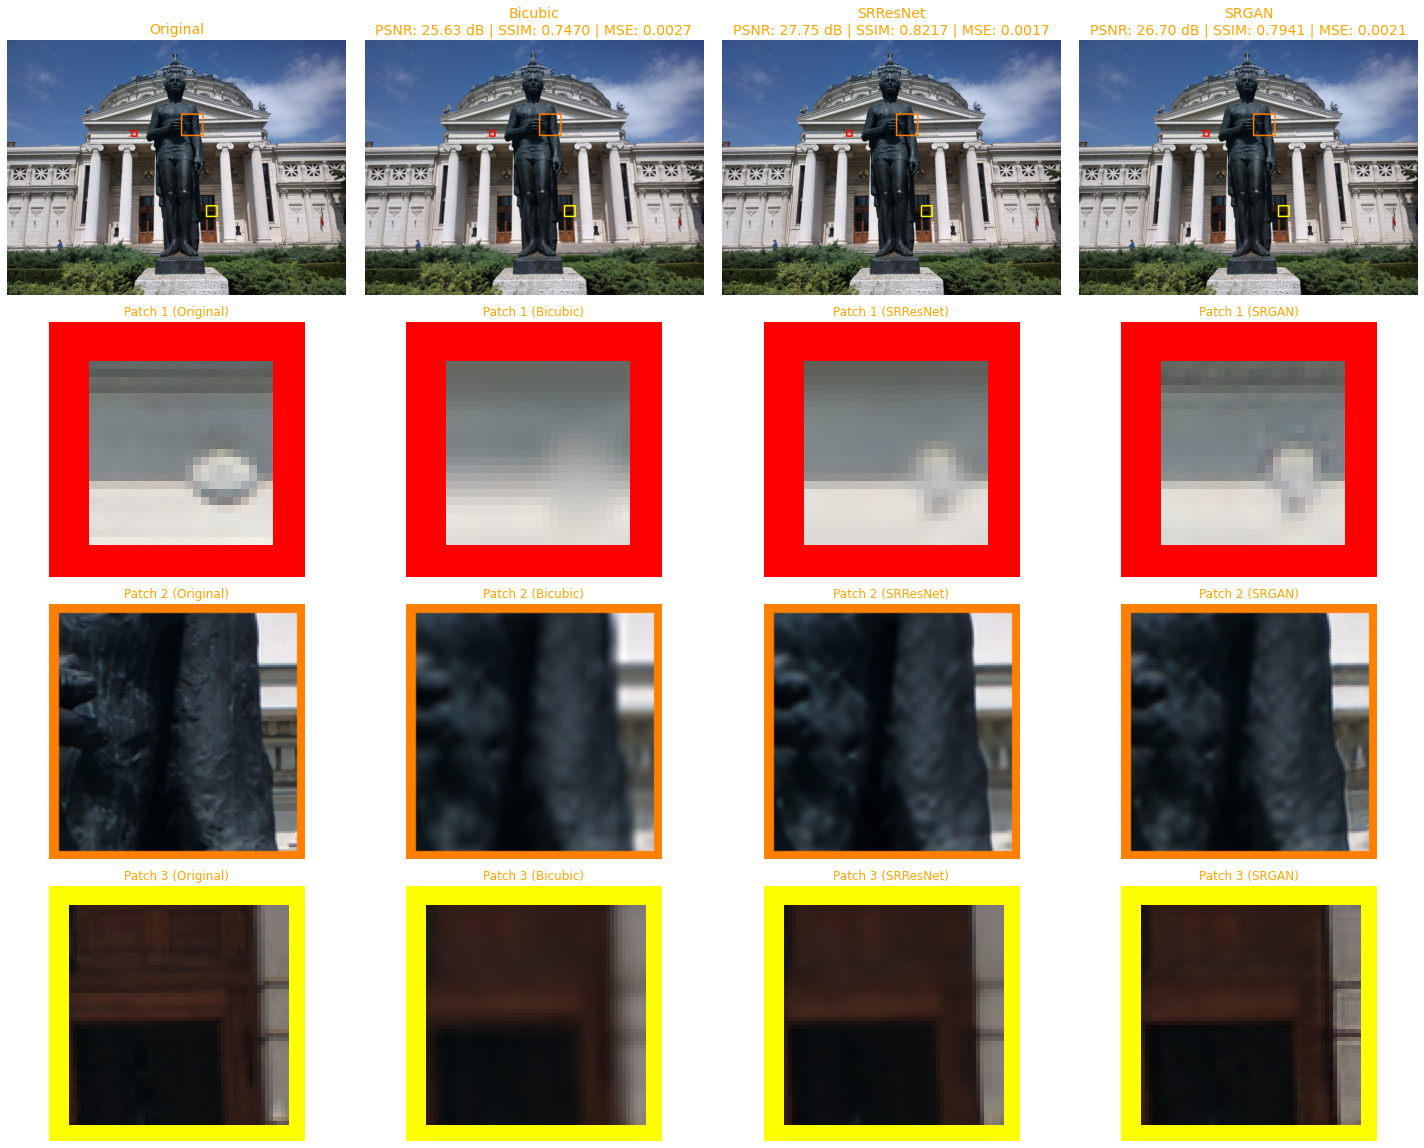

In [1]:
#Display image 1
%run display_image --original "C:/Users/User/Desktop/SRGAN - Copy/div2k_train_val/outputs/test/display_img/0812.png" --bicubic "C:/Users/User/Desktop/SRGAN - Copy/div2k_train_val/outputs/test/display_img/0812_bic.png" --srresnet "C:/Users/User/Desktop/SRGAN - Copy/div2k_train_val/outputs/test/display_img/pretrained_res_0812.png" --srgan "C:/Users/User/Desktop/SRGAN - Copy/div2k_train_val/outputs/test/display_img/srgan_res_0812.png" --patch_info 750 550 32 1050 450 128 1200 1000 64                 

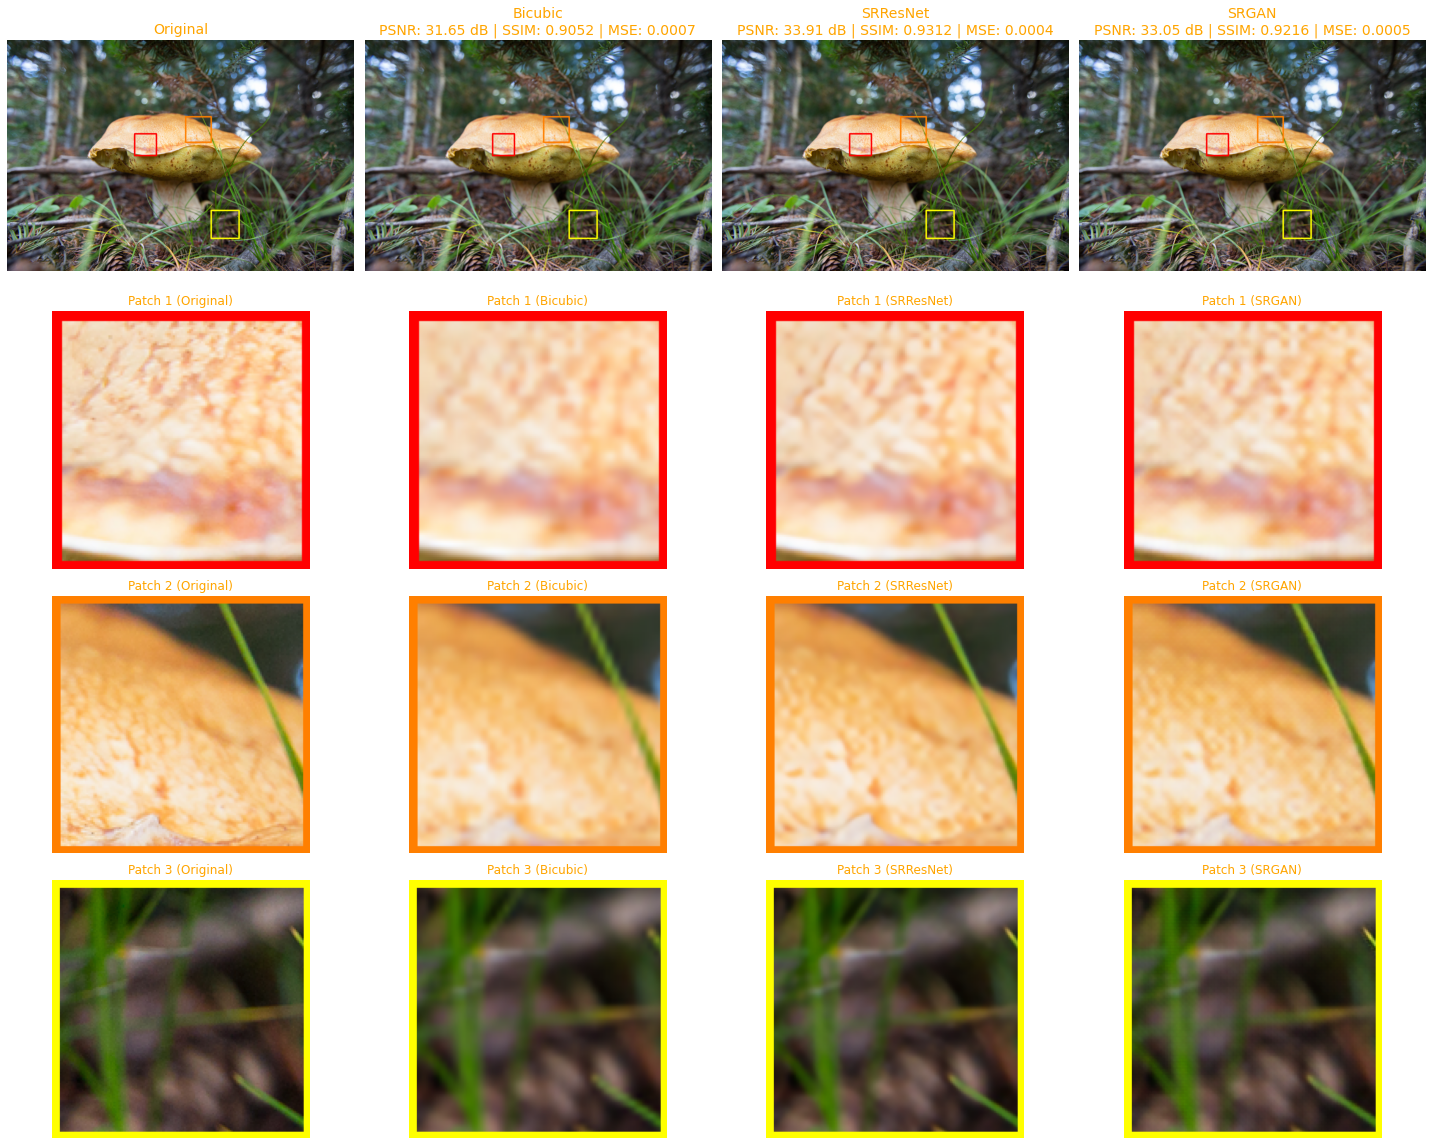

In [5]:
#Display image 2
%run display_image --original "C:/Users/User/Desktop/SRGAN - Copy/div2k_train_val/outputs/test/display_img/0815.png" --bicubic "C:/Users/User/Desktop/SRGAN - Copy/div2k_train_val/outputs/test/display_img/0815_bic.png" --srresnet "C:/Users/User/Desktop/SRGAN - Copy/div2k_train_val/outputs/test/display_img/pretrained_res_0815.png" --srgan "C:/Users/User/Desktop/SRGAN - Copy/div2k_train_val/outputs/test/display_img/srgan_res_0815.png" --patch_info 750 550 128 1050 450 150 1200 1000 164                 

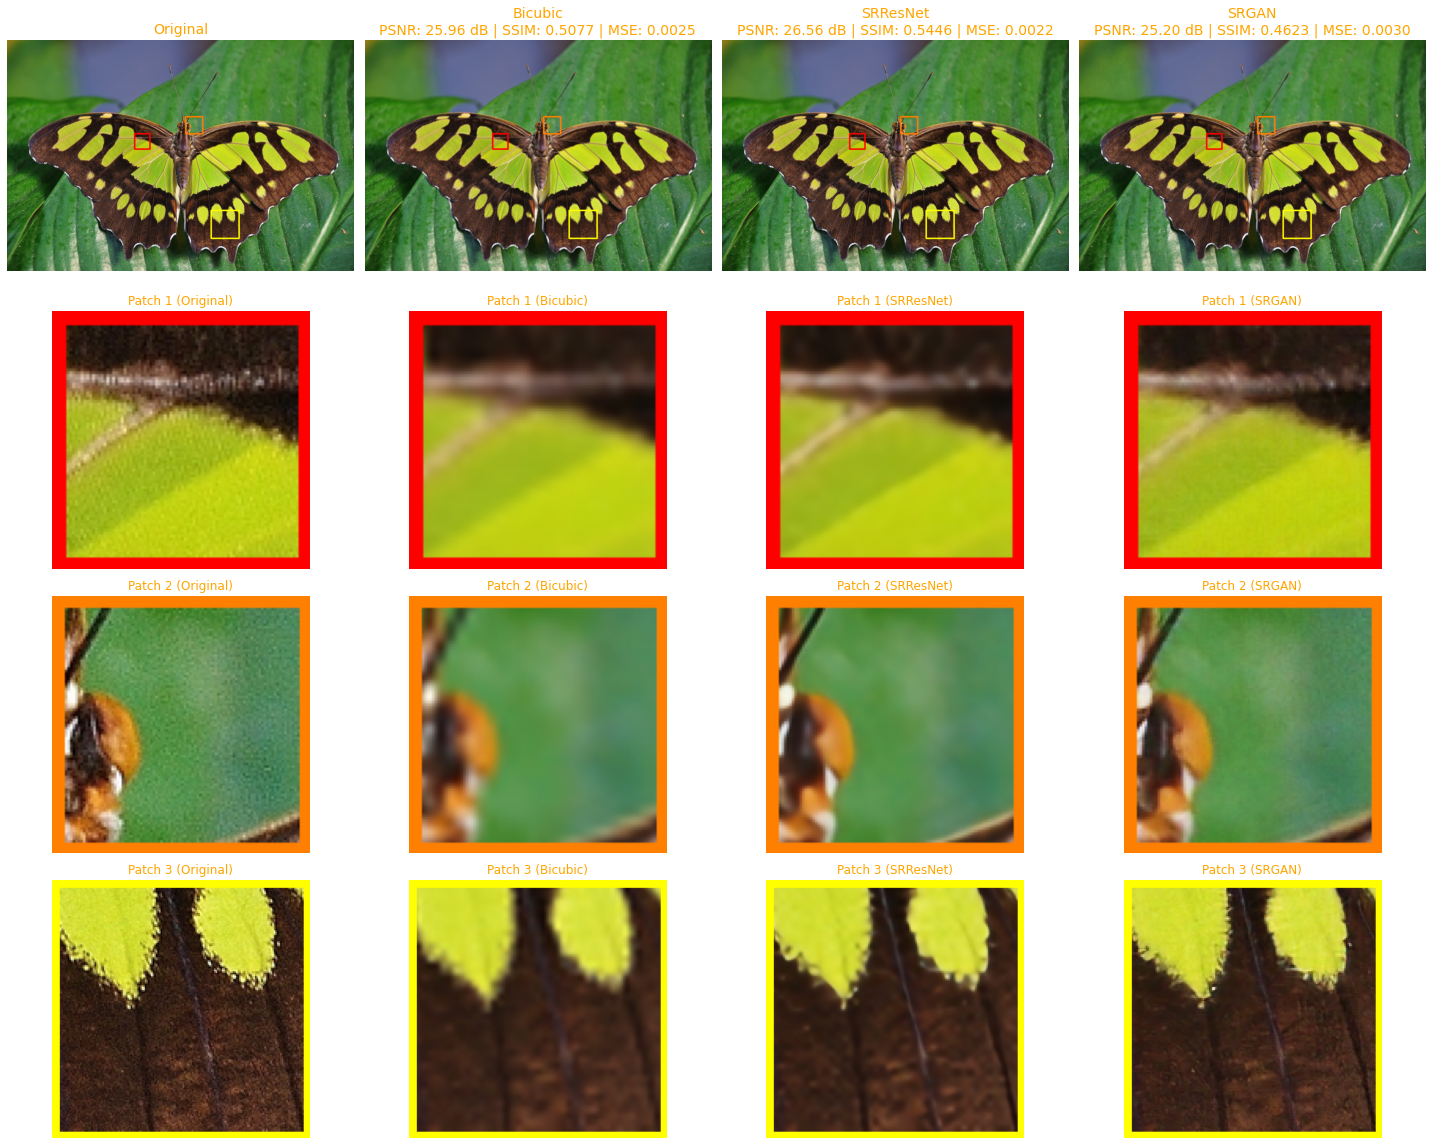

In [17]:
#Display image 3
%run display_image --original "C:/Users/User/Desktop/SRGAN - Copy/div2k_train_val/outputs/test/display_img/0829.png" --bicubic "C:/Users/User/Desktop/SRGAN - Copy/div2k_train_val/outputs/test/display_img/0829_bic.png" --srresnet "C:/Users/User/Desktop/SRGAN - Copy/div2k_train_val/outputs/test/display_img/pretrained_res_0829.png" --srgan "C:/Users/User/Desktop/SRGAN - Copy/div2k_train_val/outputs/test/display_img/srgan_res_0829_alpha.png" --patch_info 750 550 90 1050 450 100 1200 1000 164                 

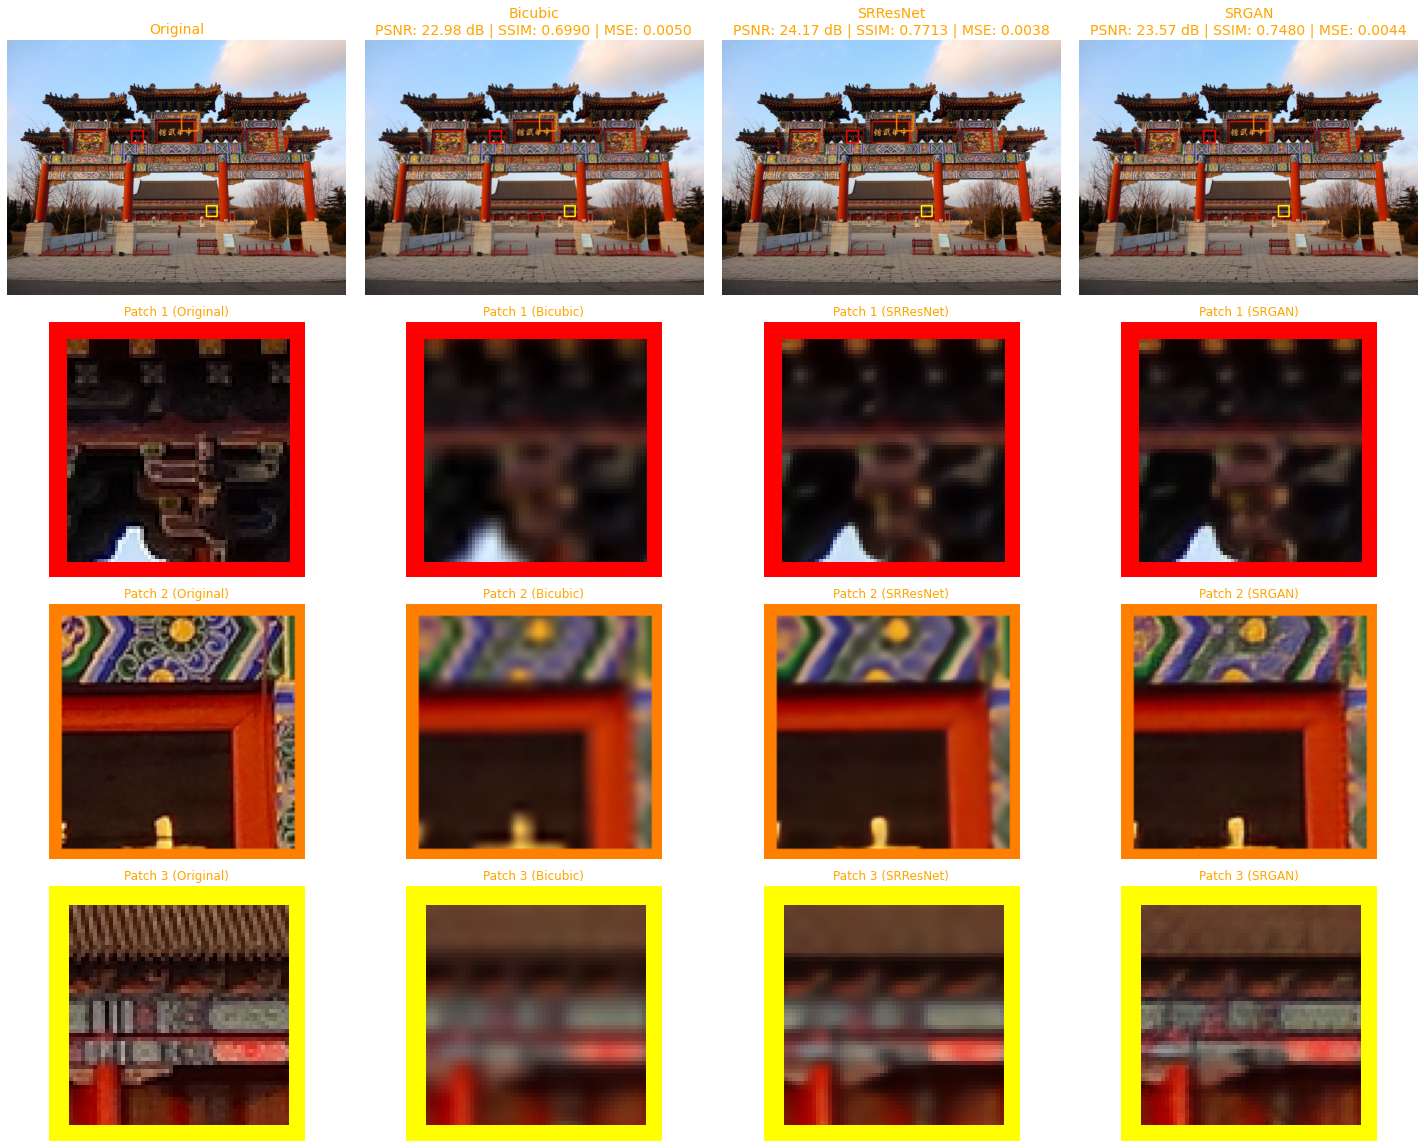

In [19]:
#Display image 4
%run display_image --original "C:/Users/User/Desktop/SRGAN - Copy/div2k_train_val/outputs/test/display_img/0826.png" --bicubic "C:/Users/User/Desktop/SRGAN - Copy/div2k_train_val/outputs/test/display_img/0826_bic.png" --srresnet "C:/Users/User/Desktop/SRGAN - Copy/div2k_train_val/outputs/test/display_img/pretrained_res_0826.png" --srgan "C:/Users/User/Desktop/SRGAN - Copy/div2k_train_val/outputs/test/display_img/srgan_res_0826.png" --patch_info 750 550 70 1050 450 100 1200 1000 64                 

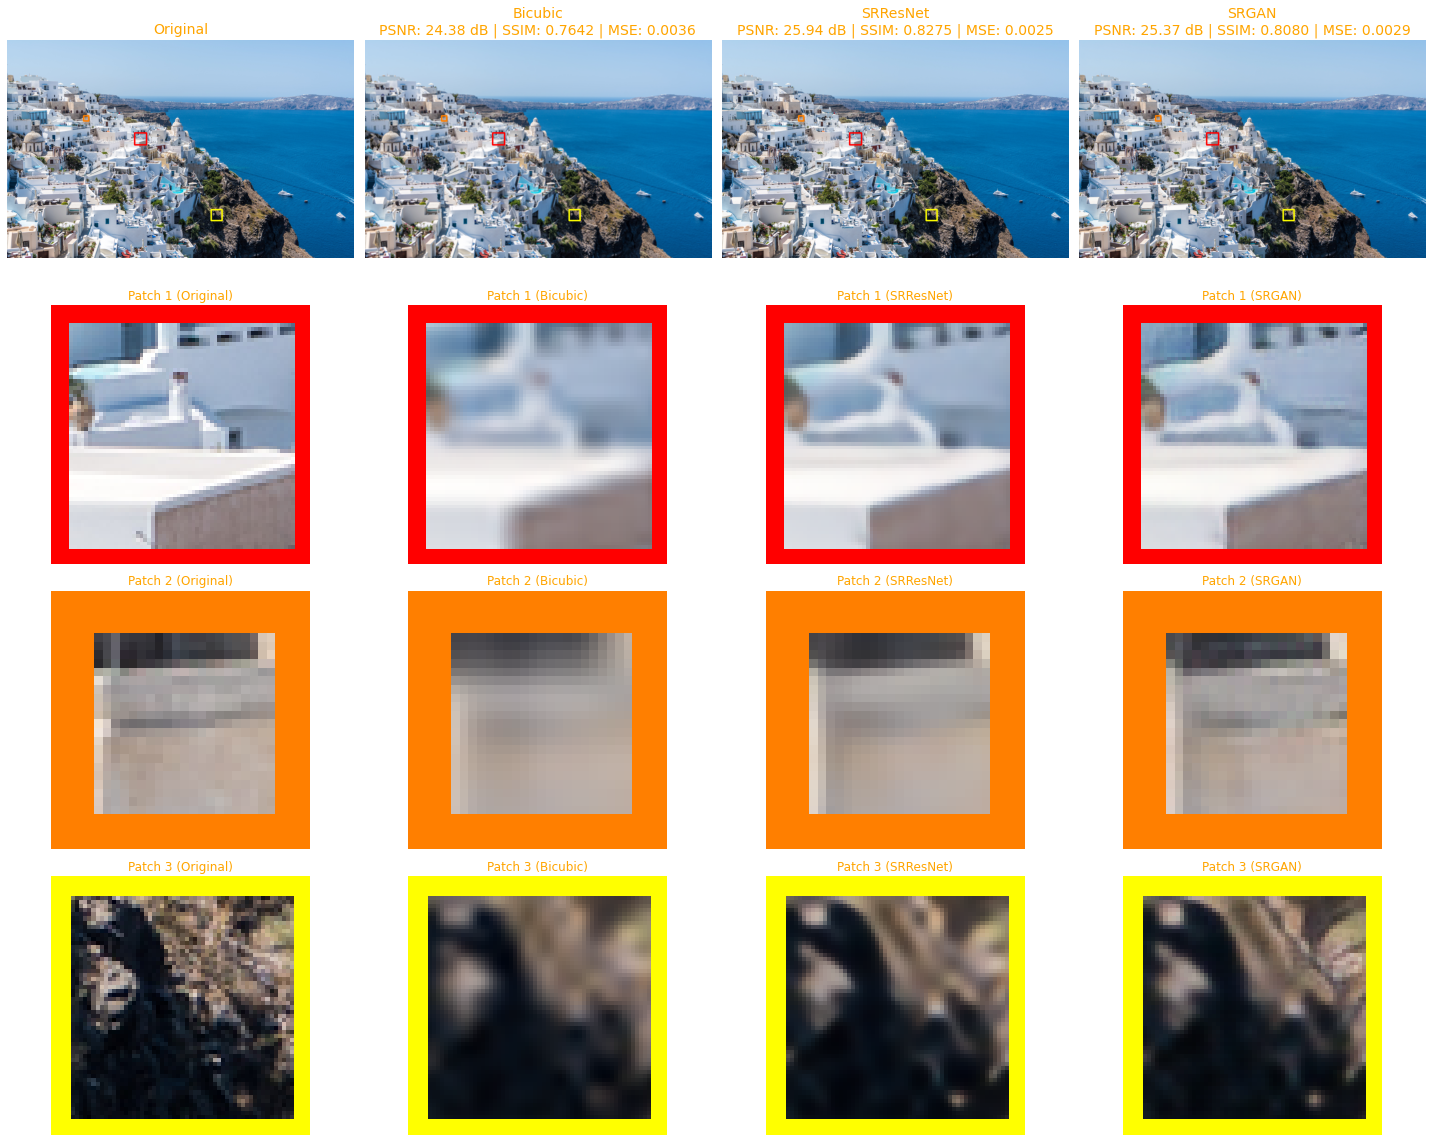

In [25]:
#Display image 4
%run display_image --original "C:/Users/User/Desktop/SRGAN - Copy/div2k_train_val/outputs/test/display_img/0823.png" --bicubic "C:/Users/User/Desktop/SRGAN - Copy/div2k_train_val/outputs/test/display_img/0823_bic.png" --srresnet "C:/Users/User/Desktop/SRGAN - Copy/div2k_train_val/outputs/test/display_img/pretrained_res_0823.png" --srgan "C:/Users/User/Desktop/SRGAN - Copy/div2k_train_val/outputs/test/display_img/srgan_res_0823.png" --patch_info 750 550 70 450 450 30 1200 1000 64                 

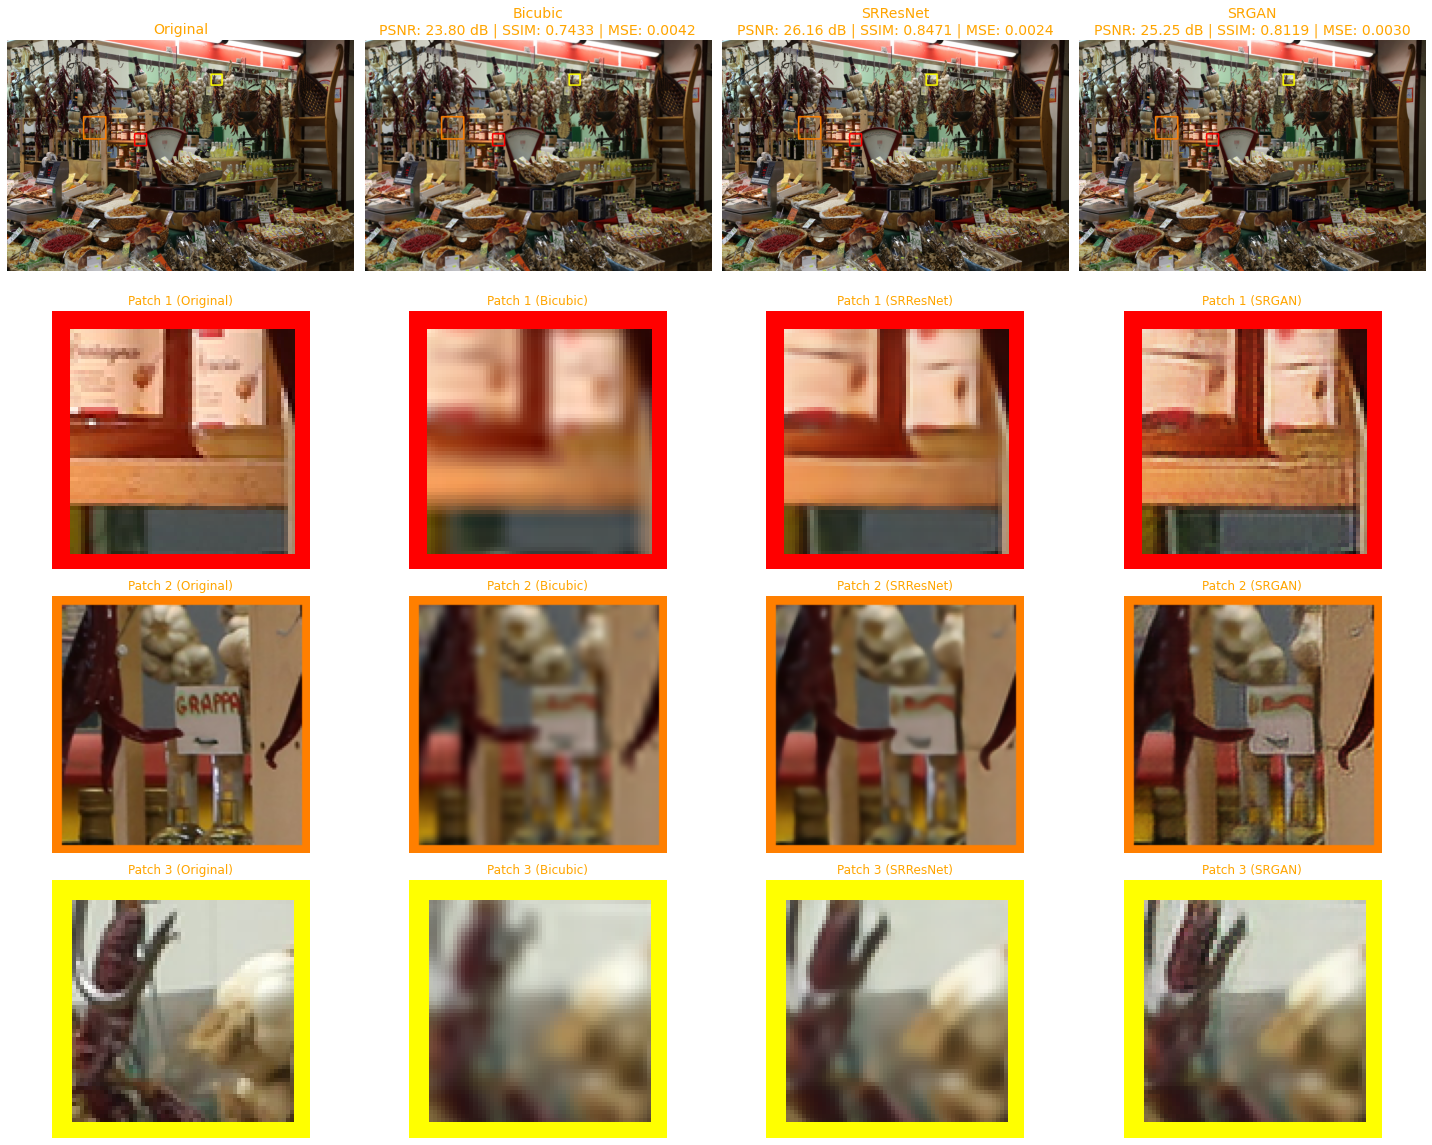

In [24]:
#Display image 5
%run display_image --original "C:/Users/User/Desktop/SRGAN - Copy/div2k_train_val/outputs/test/display_img/0837.png" --bicubic "C:/Users/User/Desktop/SRGAN - Copy/div2k_train_val/outputs/test/display_img/0837_bic.png" --srresnet "C:/Users/User/Desktop/SRGAN - Copy/div2k_train_val/outputs/test/display_img/pretrained_res_0837.png" --srgan "C:/Users/User/Desktop/SRGAN - Copy/div2k_train_val/outputs/test/display_img/srgan_res_0837.png" --patch_info 750 550 70 450 450 130 1200 200 64                 